# CNN - Modelling (Binary + AdpGauThresh + Standalone TL)

# 1. Construct MLP 

In [1]:
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Fri Sep 17 03:45:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P8    10W /  70W |      0MiB / 15109MiB |      0%    

Use MLP on the extracted features to make prediction.

In [3]:
from crack_utils import classification_block
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# define MLP model
def MLP(input_size):
    # define model input
    visible = Input(shape=(input_size, ))
    # add classification block
    layer = classification_block(visible, 16)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# 2. Pretrain Model as Standalone Feature Extractor 

Use all layes previous to the output layer.

## 2.1 VGG19


In [4]:
from tensorflow.keras.applications import VGG19

# create model instance
model = VGG19()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-09-17 03:45:54.517 ip-172-31-5-51:12091 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-17 03:45:54.590 ip-172-31-5-51:12091 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [5]:
from crack_utils import load_binary_dataset, extract_in_batch
from tensorflow.keras.applications.vgg19 import preprocess_input as pre_vgg19

SRC_BINARY = "/home/ubuntu/crack/AdpGauThresh-Binary"

x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (224, 224))
x_train = extract_in_batch(10, x_train, model, "train", pre_vgg19)
x_test = extract_in_batch(10, x_test, model, "test", pre_vgg19)
feature_length = x_train.shape[1]

Fit MLP model:

In [6]:
%%time

from crack_utils import binary_compile

# create model instance
model = MLP(feature_length)
binary_compile(model, 0.01, 0.9)

# fit the model
histories = dict()

histories["Bi_AGT_TL1_VGG19"] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 21.1 s, sys: 3.11 s, total: 24.2 s
Wall time: 11 s


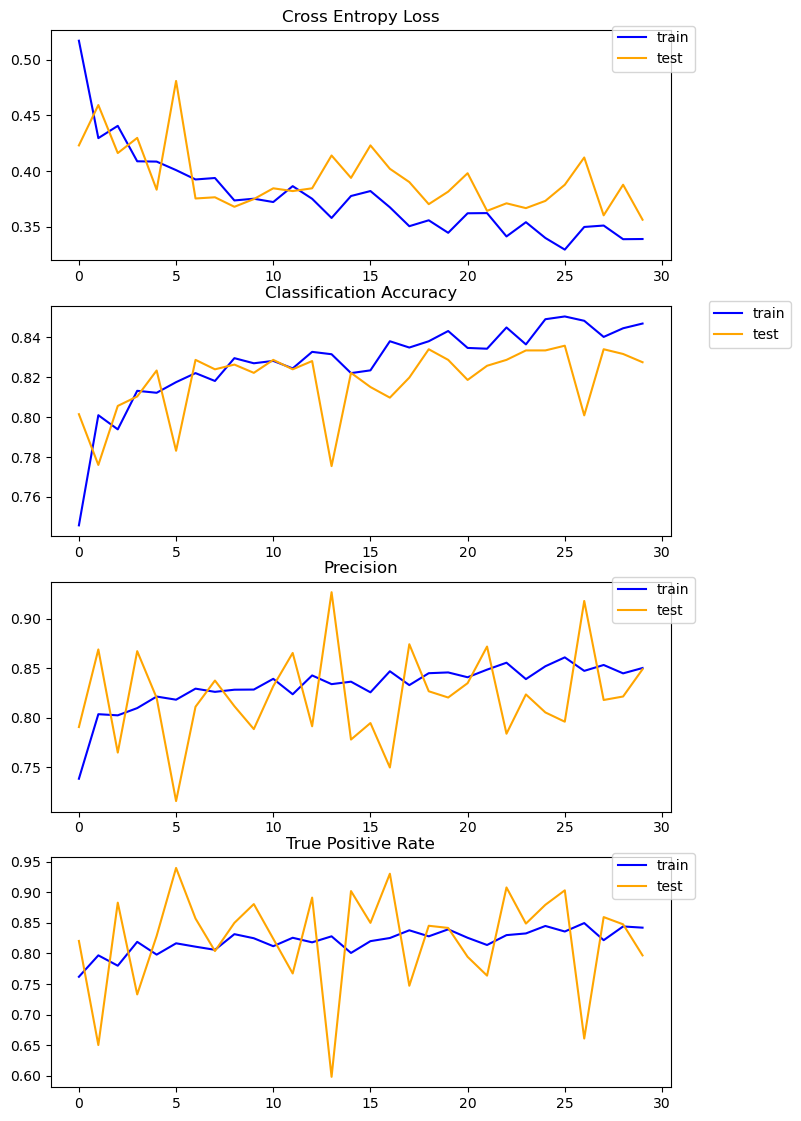

In [7]:
from crack_utils import summarize_diagnostics_binary
                                           
summarize_diagnostics_binary(histories["Bi_AGT_TL1_VGG19"], "model_plot/Bi_AGT_TL1_VGG19.png")

In [8]:
from crack_utils import show_result

show_result(model, x_test, y=y_test)

Test loss: 0.36
Test Accuracy: 0.83
Test Precision: 0.85
Test True Positive Rate: 0.80


## 2.2 ResNet152V2

In [9]:
from tensorflow.keras.applications import ResNet152V2

# create model instance
model = ResNet152V2()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [10]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input as pre_resnet_v2

del x_train, x_test
x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (224, 224))
x_train = extract_in_batch(10, x_train, model, "train", pre_resnet_v2)
x_test = extract_in_batch(10, x_test, model, "test", pre_resnet_v2)
feature_length = x_train.shape[1]

Fit MLP model:

In [11]:
%%time

# create model instance
model = MLP(feature_length)
binary_compile(model, 0.01, 0.9)

histories["Bi_AGT_TL1_ResNet152V2"] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 20 s, sys: 3.09 s, total: 23.1 s
Wall time: 9.84 s


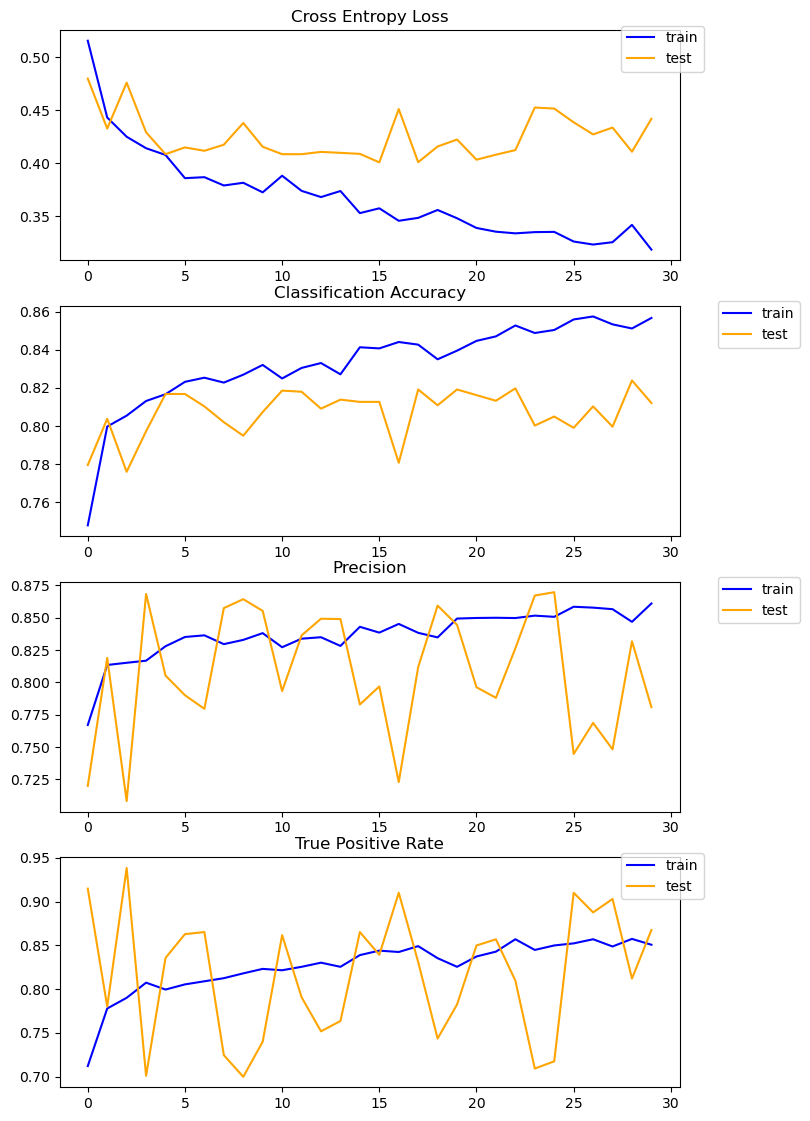

In [12]:
summarize_diagnostics_binary(histories["Bi_AGT_TL1_ResNet152V2"], 
                             "model_plot/Bi_AGT_TL1_ResNet152V2.png")

In [13]:
show_result(model, x_test, y=y_test)

Test loss: 0.44
Test Accuracy: 0.81
Test Precision: 0.78
Test True Positive Rate: 0.87


## 2.3 NASNetLarge

In [14]:
from tensorflow.keras.applications import NASNetLarge

# create model instance
model = NASNetLarge()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 30 batches:

In [15]:
from tensorflow.keras.applications.nasnet import preprocess_input as pre_nasnet

del x_train, x_test
x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (331, 331))
x_train = extract_in_batch(30, x_train, model, "train", pre_nasnet)
x_test = extract_in_batch(30, x_test, model, "test", pre_nasnet)
feature_length = x_train.shape[1]

Fit MLP model:

In [16]:
%%time

# create model instance
model = MLP(feature_length)
binary_compile(model, 0.01, 0.9)

histories["Bi_AGT_TL1_NASNetLarge"] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 21.1 s, sys: 3.08 s, total: 24.2 s
Wall time: 10.9 s


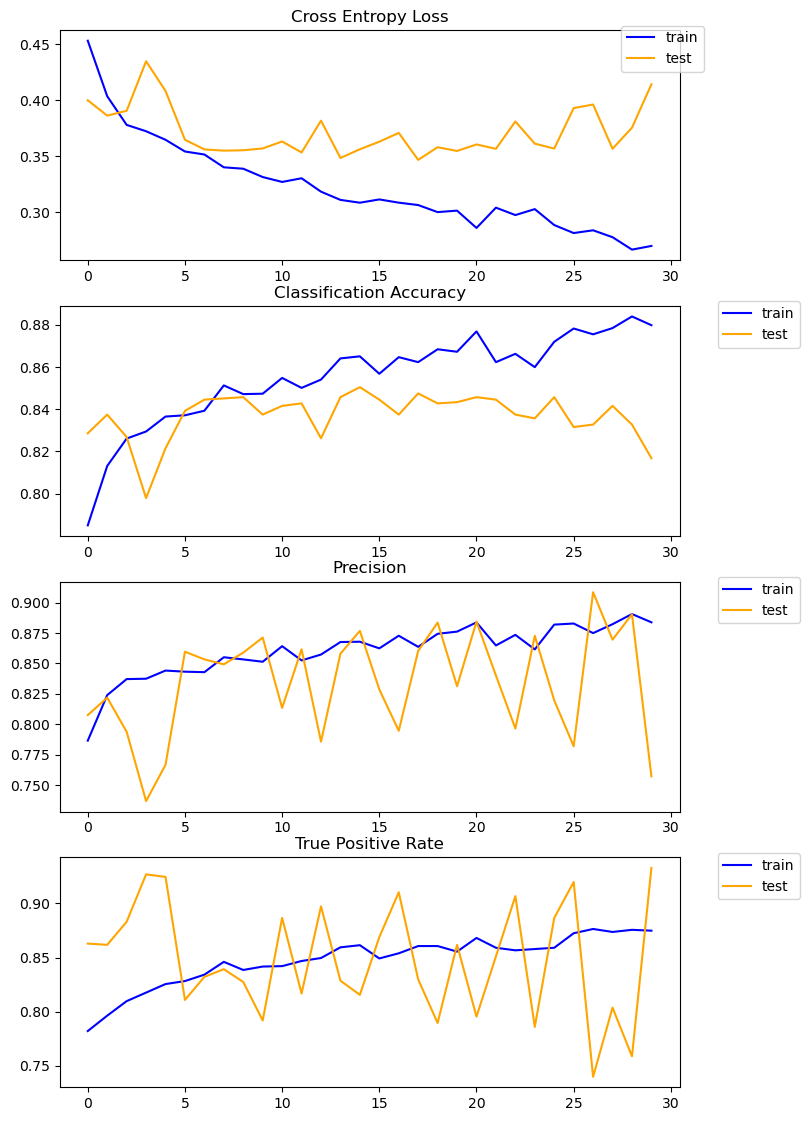

In [17]:
summarize_diagnostics_binary(histories["Bi_AGT_TL1_NASNetLarge"], "model_plot/Bi_AGT_TL1_NASNetLarge.png")

In [18]:
show_result(model, x_test, y=y_test)

Test loss: 0.41
Test Accuracy: 0.82
Test Precision: 0.76
Test True Positive Rate: 0.93


## 2.4 DenseNet201

In [19]:
from tensorflow.keras.applications import DenseNet201

# create model instance
model = DenseNet201()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [20]:
from tensorflow.keras.applications.densenet import preprocess_input as pre_densenet

del x_train, x_test
x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (224, 224))
x_train = extract_in_batch(10, x_train, model, "train", pre_densenet)
x_test = extract_in_batch(10, x_test, model, "test", pre_densenet)
feature_length = x_train.shape[1]

Fit MLP model:

In [21]:
%%time

from crack_utils import binary_compile

# create model instance
model = MLP(feature_length)
binary_compile(model, 0.01, 0.9)

histories["Bi_AGT_TL1_DenseNet201"] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 20 s, sys: 2.87 s, total: 22.9 s
Wall time: 9.7 s


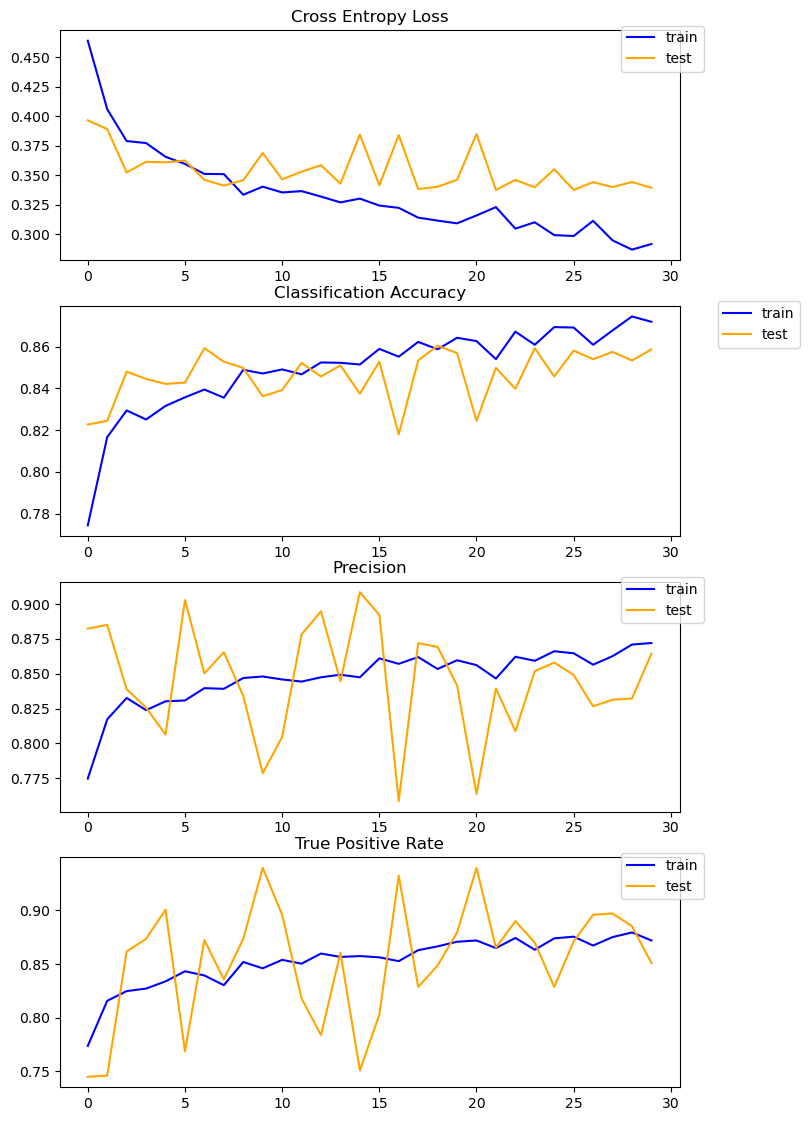

In [22]:
summarize_diagnostics_binary(histories["Bi_AGT_TL1_DenseNet201"], 
                             "model_plot/Bi_AGT_TL1_DenseNet201.png")

In [23]:
show_result(model, x_test, y=y_test)

Test loss: 0.34
Test Accuracy: 0.86
Test Precision: 0.86
Test True Positive Rate: 0.85


## 2.5 InceptionV3

In [24]:
from tensorflow.keras.applications import InceptionV3

# create model instance
model = InceptionV3()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [25]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as pre_inception_v3

del x_train, x_test
x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (299,299))
x_train = extract_in_batch(10, x_train, model, "train", pre_inception_v3)
x_test = extract_in_batch(10, x_test, model, "test", pre_inception_v3)
feature_length = x_train.shape[1]

Fit MLP model:

In [26]:
%%time

from crack_utils import binary_compile

# create model instance
model = MLP(feature_length)
binary_compile(model, 0.01, 0.9)

histories["Bi_AGT_TL1_InceptionV3"] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 20.9 s, sys: 3 s, total: 23.9 s
Wall time: 10.7 s


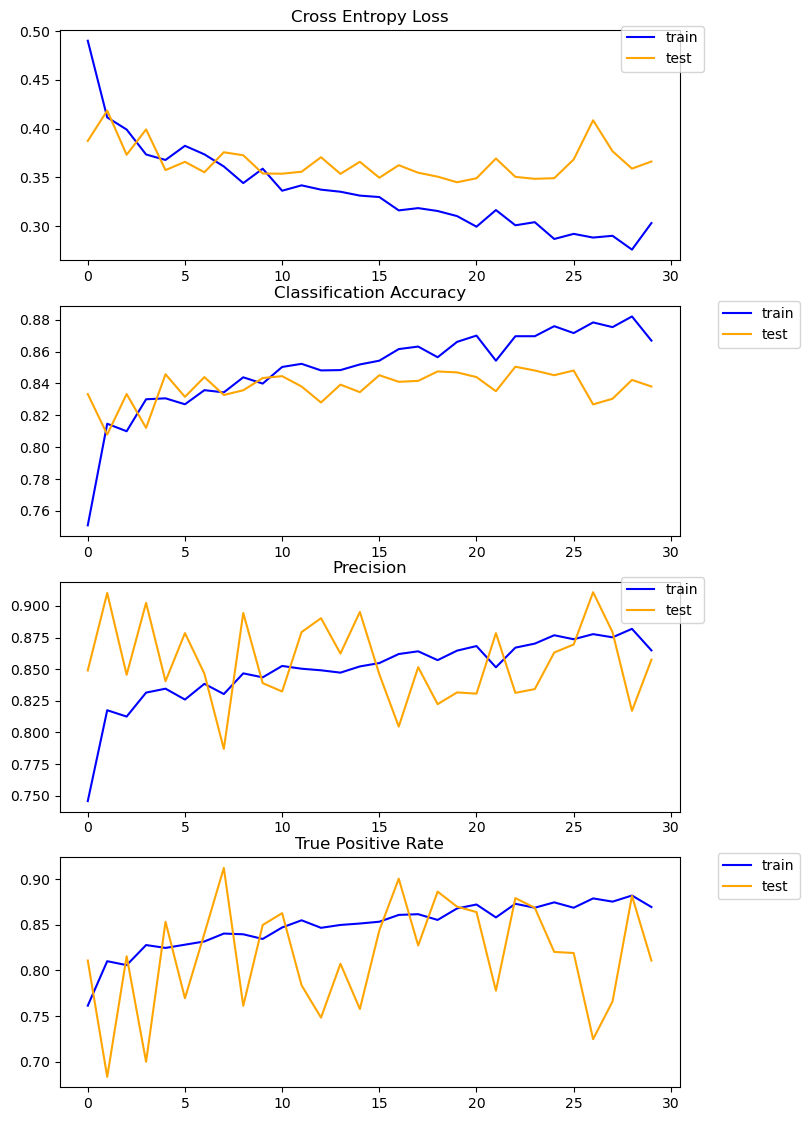

In [27]:
summarize_diagnostics_binary(histories["Bi_AGT_TL1_InceptionV3"], "model_plot/Bi_AGT_TL1_InceptionV3.png")

In [28]:
show_result(model, x_test, y=y_test)

Test loss: 0.37
Test Accuracy: 0.84
Test Precision: 0.86
Test True Positive Rate: 0.81


## 2.6 InceptionResNetV2

In [29]:
from tensorflow.keras.applications import InceptionResNetV2

# create model instance
model = InceptionResNetV2()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [30]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as pre_inception_resnet_v2

del x_train, x_test
x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (299,299))
x_train = extract_in_batch(10, x_train, model, "train", pre_inception_resnet_v2)
x_test = extract_in_batch(10, x_test, model, "test", pre_inception_resnet_v2)
feature_length = x_train.shape[1]

Fit MLP model:

In [31]:
%%time

from crack_utils import binary_compile

# create model instance
model = MLP(feature_length)
binary_compile(model, 0.01, 0.9)

histories["Bi_AGT_TL1_InceptionResNetV2"] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 19.7 s, sys: 3.1 s, total: 22.8 s
Wall time: 9.64 s


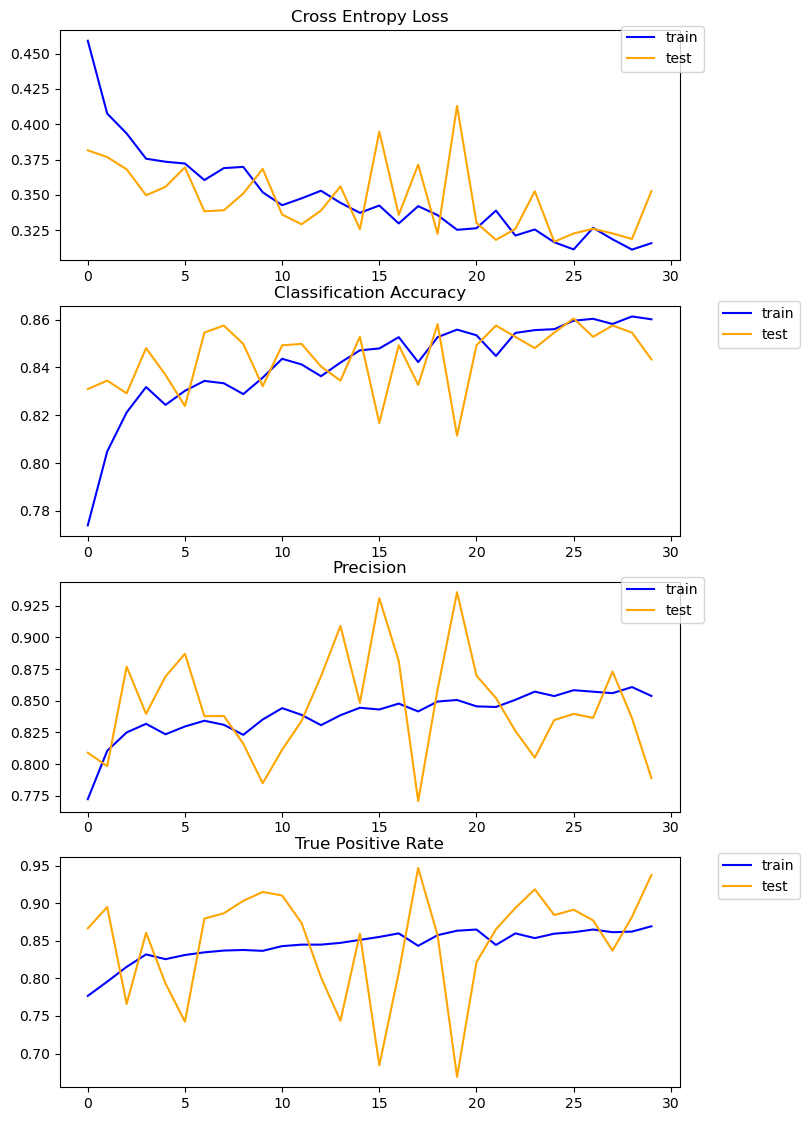

In [32]:
summarize_diagnostics_binary(histories["Bi_AGT_TL1_InceptionResNetV2"], 
                             "model_plot/Bi_AGT_TL1_InceptionResNetV2.png")

In [33]:
show_result(model, x_test, y=y_test)

Test loss: 0.35
Test Accuracy: 0.84
Test Precision: 0.79
Test True Positive Rate: 0.94


## 2.7 Xception

In [34]:
from tensorflow.keras.applications import Xception

# create model instance
model = Xception()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [35]:
from tensorflow.keras.applications.xception import preprocess_input as pre_xception

del x_train, x_test
x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (299,299))
x_train = extract_in_batch(10, x_train, model, "train", pre_xception)
x_test = extract_in_batch(10, x_test, model, "test", pre_xception)
feature_length = x_train.shape[1]

Fit MLP model:

In [36]:
%%time

from crack_utils import binary_compile

# create model instance
model = MLP(feature_length)
binary_compile(model, 0.01, 0.9)

histories["Bi_AGT_TL1_Xception"] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 20.3 s, sys: 3.23 s, total: 23.5 s
Wall time: 9.91 s


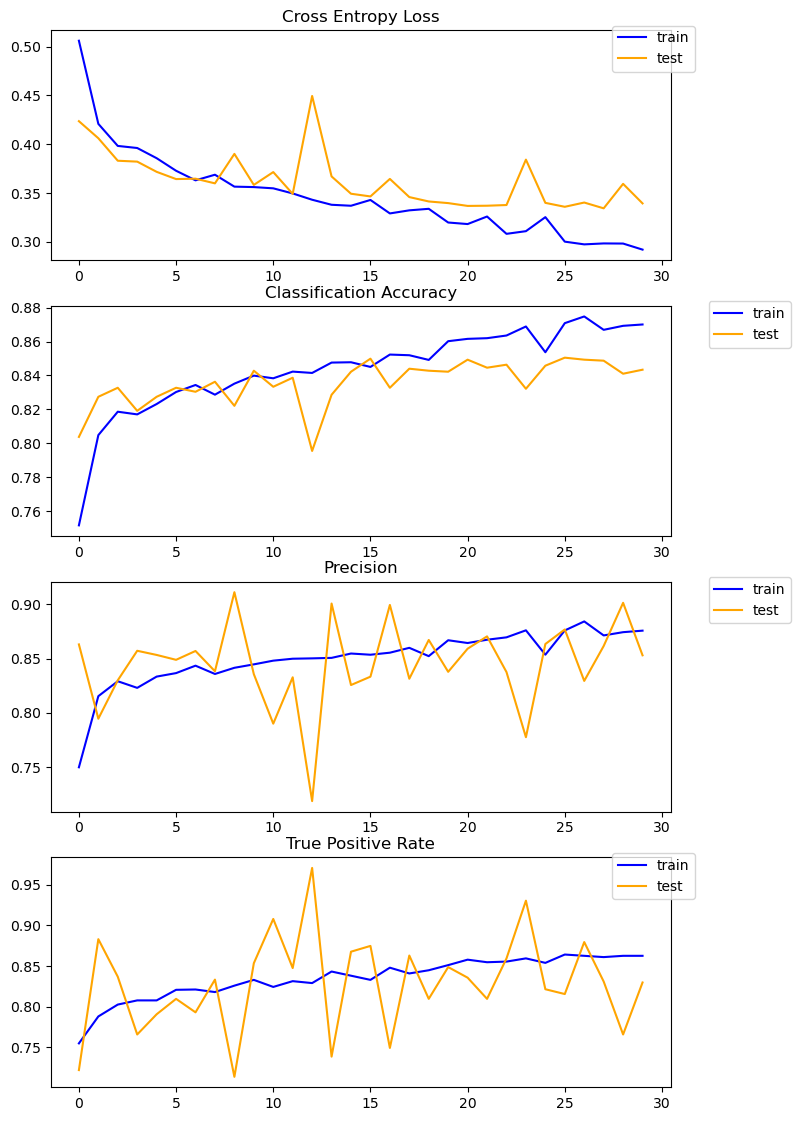

In [37]:
summarize_diagnostics_binary(histories["Bi_AGT_TL1_Xception"], "model_plot/Bi_AGT_TL1_Xception.png")

In [38]:
show_result(model, x_test, y=y_test)

Test loss: 0.34
Test Accuracy: 0.84
Test Precision: 0.85
Test True Positive Rate: 0.83


# 3. Summary

30th epoch result:

In [39]:
from crack_utils import get_percentile_result

result_30 = get_percentile_result(histories, 25)
result_30.round(2)

,Bi_AGT_TL1_VGG19,Bi_AGT_TL1_ResNet152V2,Bi_AGT_TL1_NASNetLarge,Bi_AGT_TL1_DenseNet201,Bi_AGT_TL1_InceptionV3,Bi_AGT_TL1_InceptionResNetV2,Bi_AGT_TL1_Xception
Loss,0.37,0.45,0.36,0.36,0.35,0.32,0.34
Accuracy,0.83,0.80,0.85,0.85,0.85,0.85,0.85
Precision,0.81,0.87,0.82,0.86,0.86,0.83,0.86
TPR,0.88,0.72,0.89,0.83,0.82,0.88,0.82


21-30 epochs (Average):

In [40]:
from crack_utils import get_avg_result

avg_result = get_avg_result(histories, start_epoch=21)
avg_result.round(2)

,Bi_AGT_TL1_VGG19,Bi_AGT_TL1_ResNet152V2,Bi_AGT_TL1_NASNetLarge,Bi_AGT_TL1_DenseNet201,Bi_AGT_TL1_InceptionV3,Bi_AGT_TL1_InceptionResNetV2,Bi_AGT_TL1_Xception
Loss,0.38,0.43,0.38,0.34,0.37,0.33,0.35
Accuracy,0.83,0.81,0.84,0.85,0.84,0.85,0.84
Precision,0.83,0.80,0.84,0.84,0.86,0.83,0.85
TPR,0.83,0.83,0.84,0.87,0.82,0.89,0.84


Compare each model:

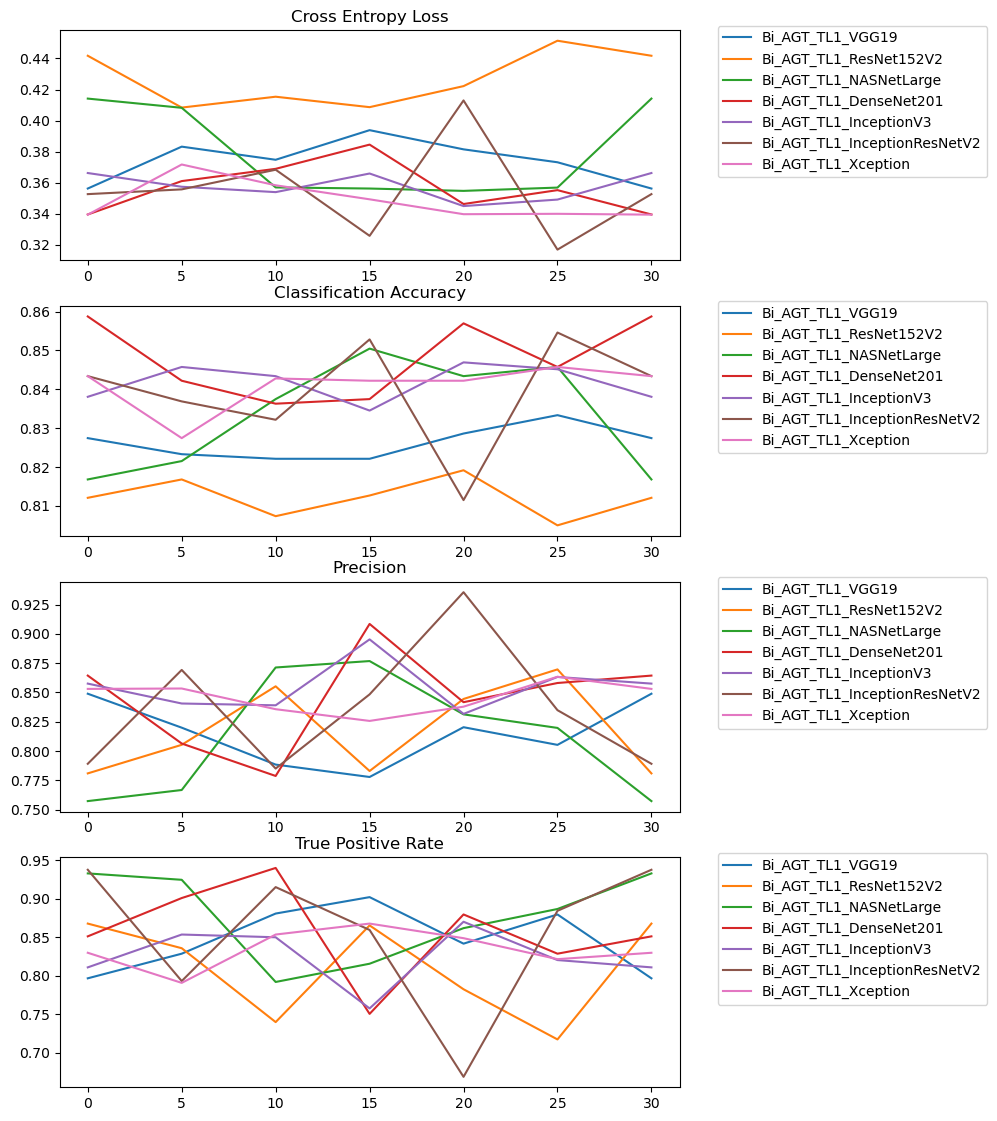

In [41]:
from crack_utils import compare_all_result

compare_all_result(histories, filename="model_plot/Compare_Bi_AGT_Standalone_TF.png", end=30, step=5)

Save epochs history:

In [42]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")